100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


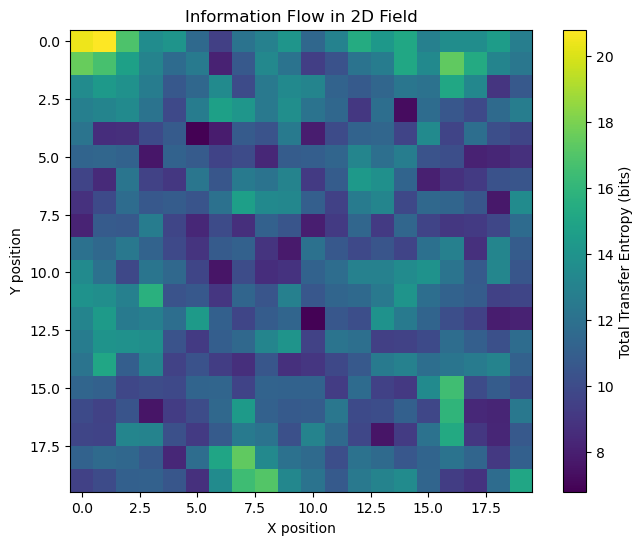

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform.transferentropy import transfer_entropy
from tqdm import tqdm  # For progress bars

# Parameters
grid_size = 20  # 5x5 grid
timesteps = 500
diffusion_rate = 0.1
noise_level = 0.05

# Initialize field (time × x × y)
field = np.zeros((timesteps, grid_size, grid_size))

# Random initial condition
field[0] = np.random.rand(grid_size, grid_size)

# Simulate diffusion-like dynamics with noise
for t in range(1, timesteps):
    for i in range(grid_size):
        for j in range(grid_size):
            # Simple diffusion (interaction with neighbors)
            neighbors = []
            if i > 0: neighbors.append(field[t-1, i-1, j])
            if i < grid_size-1: neighbors.append(field[t-1, i+1, j])
            if j > 0: neighbors.append(field[t-1, i, j-1])
            if j < grid_size-1: neighbors.append(field[t-1, i, j+1])
            
            field[t, i, j] = (1 - diffusion_rate) * field[t-1, i, j] + \
                              diffusion_rate * np.mean(neighbors) + \
                              noise_level * np.random.randn()

# Compute TE matrix (source → target)
te_matrix = np.zeros((grid_size, grid_size, grid_size, grid_size))

for i in tqdm(range(grid_size)):
    for j in range(grid_size):
        for k in range(grid_size):
            for l in range(grid_size):
                if (i, j) == (k, l):
                    continue  # Skip self-entropy
                # Extract time series for the two points
                source = field[:, i, j]
                target = field[:, k, l]
                # Normalize to discrete bins (required for TE)
                source_binned = np.digitize(source, bins=np.linspace(0, 1, 5))
                target_binned = np.digitize(target, bins=np.linspace(0, 1, 5))
                # Compute TE (history lag k=1)
                te = transfer_entropy(source_binned, target_binned, k=1)
                te_matrix[i, j, k, l] = te if not np.isnan(te) else 0.0

# Aggregate TE (net flow from (i,j) to others)
net_te = te_matrix.sum(axis=(2, 3))

plt.figure(figsize=(8, 6))
plt.imshow(net_te, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Total Transfer Entropy (bits)')
plt.title("Information Flow in 2D Field")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()

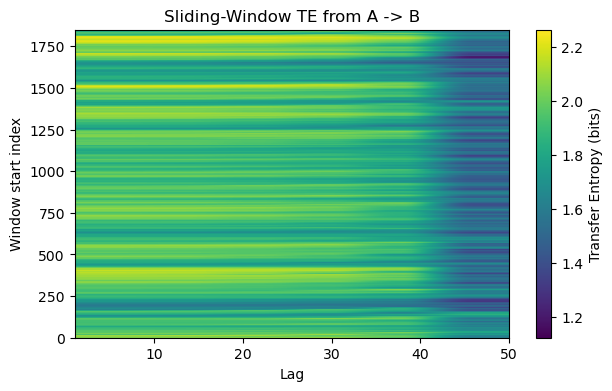

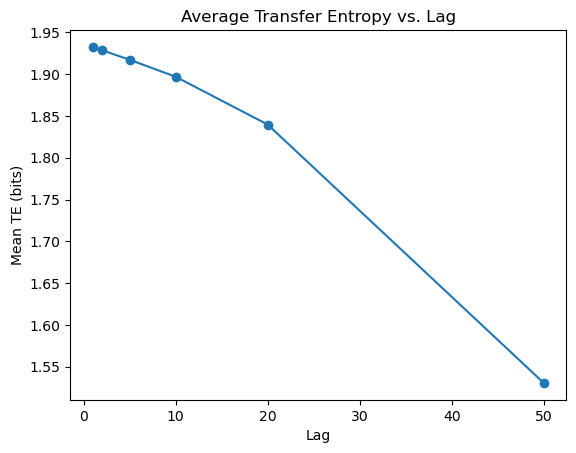

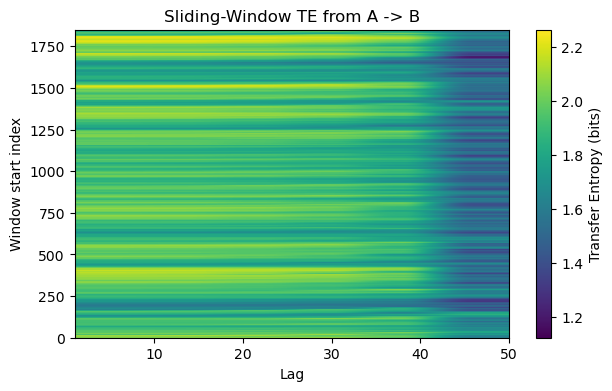

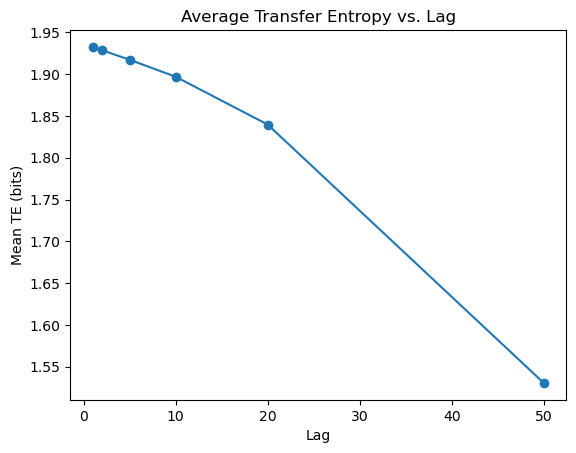

In [11]:
def discretize(data, nbins=16):
    """
    Discretize 1D continuous data into 'nbins' bins, returning
    an array of integer bin indices (0..nbins-1).
    """
    data_min, data_max = np.min(data), np.max(data)
    # Handle constant data:
    if data_min == data_max:
        return np.zeros_like(data, dtype=int)
    
    bin_edges = np.linspace(data_min, data_max, nbins+1)
    bin_indices = np.digitize(data, bin_edges) - 1
    # Ensure it stays within [0, nbins-1]
    bin_indices = np.clip(bin_indices, 0, nbins-1)
    return bin_indices

def transfer_entropy_continuous(x, y, bins=16, lag=1, eps=1e-12):
    """
    Estimate Transfer Entropy T_{X->Y} for continuous 1D arrays x, y using
    a naive histogram-based approach with single lag (lag=1 by default).

    T_{X->Y} = sum p(x_t, y_t, y_{t+1}) * log2( p(y_{t+1}| x_t, y_t) / p(y_{t+1} | y_t) )

    Args:
        x, y : 1D numpy arrays (same length).
        bins : number of bins for discretization.
        lag  : time shift for 'x' relative to 'y_{t+1}'.
        eps  : small constant to avoid log(0).

    Returns:
        TE in bits (since we use log base 2).
    """
    length = len(x)
    if len(y) != length:
        raise ValueError("x and y must have the same length.")
    if length <= lag:
        raise ValueError("Time series too short for the given lag.")

    # We'll consider points from t = 0..(N - lag - 1)
    # so that y_{t+1} is valid at t+1, x_t at t, etc.
    # If lag=1, we skip the last point.
    x_t = x[:-lag-1]         # up to N-lag-1
    y_t = y[:-lag-1]
    y_next = y[1:-lag]       # (t+1)

    # Discretize each
    x_bin = discretize(x_t, bins)
    y_bin = discretize(y_t, bins)
    yn_bin = discretize(y_next, bins)

    # Combine into a single array for 3D histogram
    data_3d = np.vstack([x_bin, y_bin, yn_bin]).T  # shape (num_points, 3)

    counts_3d, edges = np.histogramdd(data_3d, bins=(bins, bins, bins))
    p_xyz = counts_3d / np.sum(counts_3d)  # p(x_t, y_t, y_{t+1})

    # We also need:
    #  p(x_t, y_t) = sum over y_{t+1}
    #  p(y_t, y_{t+1}) = sum over x_t
    p_xy = np.sum(p_xyz, axis=2)  # shape (bins, bins)
    p_yy = np.sum(p_xyz, axis=0)  # shape (bins, bins)
    p_y  = np.sum(p_yy, axis=1)   # p(y_t)

    te_val = 0.0
    # Loop over all bins
    for i_x in range(bins):
        for i_y in range(bins):
            for i_yn in range(bins):
                p_val = p_xyz[i_x, i_y, i_yn]
                if p_val <= 0:
                    continue

                p_xy_val = p_xy[i_x, i_y]
                if p_xy_val <= 0:
                    continue

                p_yy_val = p_yy[i_y, i_yn]
                if p_y[i_y] <= 0:
                    continue

                # p(y_{t+1} | x_t, y_t)
                p_cond1 = p_val / p_xy_val
                # p(y_{t+1} | y_t)
                p_cond2 = p_yy_val / p_y[i_y]

                te_val += p_val * np.log2( (p_cond1 + eps) / (p_cond2 + eps) )

    return te_val

def measure_te_sliding_window(x, y, window_size=100, lags=None, bins=16):
    """
    Compute Transfer Entropy T_{X->Y} in a sliding-window manner for multiple lags.

    Args:
        x, y         : 1D arrays, same length.
        window_size  : length of each time window.
        lags         : list of integer lags (e.g. [1,2,5]) to evaluate.
        bins         : number of bins for histogram-based TE.

    Returns:
        te_matrix : 2D array of shape (num_windows, len(lags)).
                    te_matrix[w, i] = TE for window w at lag lags[i].
        valid_starts : list of window start indices used.
    """
    if lags is None:
        lags = [1, 2, 5, 10]

    length = len(x)
    assert len(y) == length, "x and y must have the same length."

    max_lag = max(lags)
    # We'll need t+window_size+max_lag <= length for valid indexing
    # Because transfer_entropy_continuous() itself needs to skip last sample,
    # so let's be conservative and ensure there's enough room.
    num_windows = length - window_size - max_lag
    if num_windows <= 0:
        raise ValueError("Time series too short for the given window_size and max_lag.")

    te_matrix = np.zeros((num_windows, len(lags)))
    valid_starts = []

    for w in range(num_windows):
        # Window is x[w : w+window_size], y[w : w+window_size]
        x_win = x[w : w + window_size]
        y_win = y[w : w + window_size]
        
        for i, lag in enumerate(lags):
            # We'll pass x_win, y_win to the TE function with the specified lag
            te_val = transfer_entropy_continuous(x_win, y_win, bins=bins, lag=lag)
            te_matrix[w, i] = te_val

        valid_starts.append(w)

    return te_matrix, valid_starts

if __name__ == "__main__":
    # ----------------------------
    # 1. Generate synthetic data
    # ----------------------------
    np.random.seed(42)
    N = 2000
    A = np.random.randn(N)  # random driving signal
    # B depends partly on A shifted by 1
    B = 0.7 * np.roll(A, 1) + 0.3 * np.random.randn(N)

    # ----------------------------
    # 2. Define sliding-window parameters
    # ----------------------------
    window_size = 100
    lags = [1, 2, 5, 10, 20, 50]  # different time lags to check
    bins = 16  # histogram bins

    # ----------------------------
    # 3. Compute TE in sliding windows
    # ----------------------------
    te_matrix, valid_starts = measure_te_sliding_window(
        A, B, window_size=window_size, lags=lags, bins=bins
    )
    # te_matrix: shape (num_windows, len(lags))

    # ----------------------------
    # 4. Visualize
    # ----------------------------
    # a) TE heatmap: rows=window index, cols=lag
    plt.figure(figsize=(7, 4))
    plt.imshow(te_matrix, aspect='auto', origin='lower',
               extent=[lags[0], lags[-1], valid_starts[0], valid_starts[-1]])
    plt.colorbar(label='Transfer Entropy (bits)')
    plt.xlabel('Lag')
    plt.ylabel('Window start index')
    plt.title('Sliding-Window TE from A -> B')
    plt.show()

    # b) Average TE across all windows for each lag
    te_mean = np.mean(te_matrix, axis=0)
    plt.figure()
    plt.plot(lags, te_mean, marker='o')
    plt.xlabel('Lag')
    plt.ylabel('Mean TE (bits)')
    plt.title('Average Transfer Entropy vs. Lag')
    plt.show()

if __name__ == "__main__":
    # ----------------------------
    # 1. Generate synthetic data
    # ----------------------------
    np.random.seed(42)
    N = 2000
    A = np.random.randn(N)  # random driving signal
    # B depends partly on A shifted by 1
    B = 0.7 * np.roll(A, 1) + 0.3 * np.random.randn(N)

    # ----------------------------
    # 2. Define sliding-window parameters
    # ----------------------------
    window_size = 100
    lags = [1, 2, 5, 10, 20, 50]  # different time lags to check
    bins = 16  # histogram bins

    # ----------------------------
    # 3. Compute TE in sliding windows
    # ----------------------------
    te_matrix, valid_starts = measure_te_sliding_window(
        A, B, window_size=window_size, lags=lags, bins=bins
    )
    # te_matrix: shape (num_windows, len(lags))

    # ----------------------------
    # 4. Visualize
    # ----------------------------
    # a) TE heatmap: rows=window index, cols=lag
    plt.figure(figsize=(7, 4))
    plt.imshow(te_matrix, aspect='auto', origin='lower',
               extent=[lags[0], lags[-1], valid_starts[0], valid_starts[-1]])
    plt.colorbar(label='Transfer Entropy (bits)')
    plt.xlabel('Lag')
    plt.ylabel('Window start index')
    plt.title('Sliding-Window TE from A -> B')
    plt.show()

    # b) Average TE across all windows for each lag
    te_mean = np.mean(te_matrix, axis=0)
    plt.figure()
    plt.plot(lags, te_mean, marker='o')
    plt.xlabel('Lag')
    plt.ylabel('Mean TE (bits)')
    plt.title('Average Transfer Entropy vs. Lag')
    plt.show()


Row i: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.16it/s]


Shape of TE matrix: (5, 5, 5, 5)
Top 5 TE values (source -> target) across the grid:
  TE((4, 2) -> (2, 1)) = 1.4092
  TE((3, 2) -> (1, 0)) = 1.3958
  TE((2, 1) -> (1, 0)) = 1.3902
  TE((2, 3) -> (1, 0)) = 1.3810
  TE((2, 2) -> (1, 0)) = 1.3704


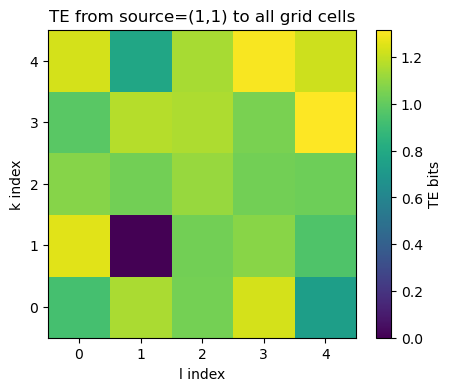

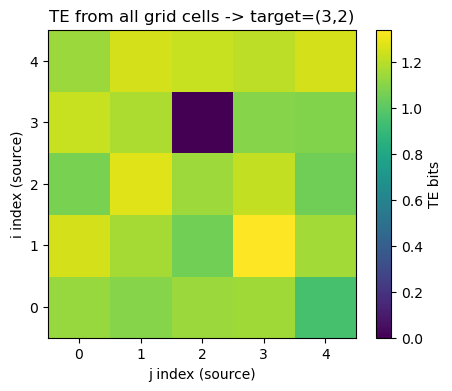

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # for a progress bar, optional

# --- From your existing code snippets ---
def discretize(data, nbins=16):
    """
    Discretize 1D continuous data into 'nbins' bins, returning
    an array of integer bin indices (0..nbins-1).
    """
    data_min, data_max = np.min(data), np.max(data)
    # Handle constant data:
    if data_min == data_max:
        return np.zeros_like(data, dtype=int)
    
    bin_edges = np.linspace(data_min, data_max, nbins+1)
    bin_indices = np.digitize(data, bin_edges) - 1
    # Ensure it stays within [0, nbins-1]
    bin_indices = np.clip(bin_indices, 0, nbins-1)
    return bin_indices

def transfer_entropy_continuous(x, y, bins=16, lag=1, eps=1e-12):
    """
    Estimate Transfer Entropy T_{X->Y} for continuous 1D arrays x, y using
    a naive histogram-based approach with single lag (lag=1 by default).

    T_{X->Y} = sum p(x_t, y_t, y_{t+1}) * log2( p(y_{t+1}| x_t, y_t) / p(y_{t+1} | y_t) )

    Args:
        x, y : 1D numpy arrays (same length).
        bins : number of bins for discretization.
        lag  : time shift for 'x' relative to 'y_{t+1}'.
        eps  : small constant to avoid log(0).

    Returns:
        TE in bits (since we use log base 2).
    """
    length = len(x)
    if len(y) != length:
        raise ValueError("x and y must have the same length.")
    if length <= lag:
        raise ValueError("Time series too short for the given lag.")

    # We'll consider points from t = 0..(length - lag - 1)
    # so that y_{t+1} is valid, x_t at t, etc.
    if length - lag - 1 <= 0:
        return np.nan  # not enough data

    x_t = x[:-lag-1]         
    y_t = y[:-lag-1]
    y_next = y[1:-lag]       

    # Discretize each
    x_bin = discretize(x_t, bins)
    y_bin = discretize(y_t, bins)
    yn_bin = discretize(y_next, bins)

    # Combine into a single array for 3D histogram
    data_3d = np.vstack([x_bin, y_bin, yn_bin]).T  # shape (num_points, 3)

    counts_3d, edges = np.histogramdd(data_3d, bins=(bins, bins, bins))
    total_count = np.sum(counts_3d)
    if total_count == 0:
        return np.nan

    p_xyz = counts_3d / total_count  # p(x_t, y_t, y_{t+1})

    # We also need:
    #  p(x_t, y_t) = sum over y_{t+1}
    #  p(y_t, y_{t+1}) = sum over x_t
    p_xy = np.sum(p_xyz, axis=2)  # shape (bins, bins)
    p_yy = np.sum(p_xyz, axis=0)  # shape (bins, bins)
    p_y  = np.sum(p_yy, axis=1)   # shape (bins,)

    te_val = 0.0
    for i_x in range(bins):
        for i_y in range(bins):
            for i_yn in range(bins):
                p_val = p_xyz[i_x, i_y, i_yn]
                if p_val <= 0:
                    continue

                p_xy_val = p_xy[i_x, i_y]
                if p_xy_val <= 0:
                    continue

                p_yy_val = p_yy[i_y, i_yn]
                if p_y[i_y] <= 0:
                    continue

                # p(y_{t+1} | x_t, y_t)
                p_cond1 = p_val / p_xy_val
                # p(y_{t+1} | y_t)
                p_cond2 = p_yy_val / p_y[i_y]

                te_val += p_val * np.log2((p_cond1 + eps) / (p_cond2 + eps))

    return te_val

def measure_spatial_te(field, bins=16, lag=1):
    """
    Compute pairwise Transfer Entropy between all pairs of spatial locations 
    in a 2D field (across time).

    Args:
        field: 3D np.array, shape = (T, Nx, Ny). 
               field[t, i, j] = value at time t, spatial coords (i, j).
        bins : number of bins for discretization in TE.
        lag  : temporal lag for TE (X_t -> Y_{t+lag}).

    Returns:
        te_matrix: 4D np.array, shape = (Nx, Ny, Nx, Ny), 
                   where te_matrix[i, j, k, l] = TE from (i, j)->(k, l).
    """
    T, Nx, Ny = field.shape
    te_matrix = np.zeros((Nx, Ny, Nx, Ny), dtype=np.float64)

    for i in tqdm(range(Nx), desc="Row i"):
        for j in range(Ny):
            source_series = field[:, i, j]  # shape (T,)

            for k in range(Nx):
                for l in range(Ny):
                    if (i == k) and (j == l):
                        # Optionally skip self-entropy
                        te_matrix[i, j, k, l] = 0.0
                        continue

                    target_series = field[:, k, l]  # shape (T,)

                    # Compute TE: source -> target
                    te_val = transfer_entropy_continuous(
                        source_series, target_series,
                        bins=bins, lag=lag
                    )

                    # If TE is NaN (insufficient data, etc.), set 0
                    te_matrix[i, j, k, l] = 0.0 if np.isnan(te_val) else te_val

    return te_matrix

if __name__ == "__main__":
    import numpy as np
    from tqdm import tqdm  # if you want a progress bar

    # 1. Generate synthetic data: T x Nx x Ny
    T = 100
    Nx = 5
    Ny = 5

    np.random.seed(0)
    field = np.random.randn(T, Nx, Ny)

    # Optional: add some coupling pattern
    # For instance, let's say field[:, 3, 2] depends on field[:, 1, 1] with a lag=1
    # This is just a toy demonstration
    for t in range(1, T):
        field[t, 3, 2] += 0.8 * field[t-1, 1, 1]  # mild injection of neighbor's previous data

    # 2. Compute pairwise TE across the entire 5x5 grid
    #    The result is a 4D array: (Nx, Ny, Nx, Ny)
    te_mat = measure_spatial_te(field, bins=8, lag=1)

    print("Shape of TE matrix:", te_mat.shape)  # (5, 5, 5, 5)

    # 3. Example: Let's see which source->target pairs have the highest TE
    #    We'll flatten it except for the last dimension,
    #    or we can unravel the 4D index.
    te_flat = te_mat.reshape(Nx*Ny, Nx*Ny)
    top_indices = np.dstack(np.unravel_index(np.argsort(te_flat.ravel())[::-1], te_flat.shape))[0]

    print("Top 5 TE values (source -> target) across the grid:")
    for idx in range(5):
        src_idx, tgt_idx = top_indices[idx]
        i_s, j_s = divmod(src_idx, Ny)
        i_t, j_t = divmod(tgt_idx, Ny)
        print(f"  TE({(i_s, j_s)} -> {(i_t, j_t)}) = {te_mat[i_s, j_s, i_t, j_t]:.4f}")

# Suppose we want to visualize TE from a single source cell (i_s, j_s) to all targets
i_s, j_s = (1, 1)  # pick whichever source cell you want

# Extract the 2D slice: TE from (i_s, j_s) -> (k, l)
te_from_source = te_mat[i_s, j_s, :, :]  # shape (N_x, N_y)

plt.figure(figsize=(5, 4))
plt.imshow(te_from_source, origin='lower', cmap='viridis')
plt.colorbar(label='TE bits')
plt.title(f"TE from source=({i_s},{j_s}) to all grid cells")
plt.xlabel('l index')
plt.ylabel('k index')
plt.show()

# Suppose we want TE for all sources -> one specific target cell (k_t, l_t)
k_t, l_t = (3, 2)  # pick whichever target cell

# te_mat[i, j, k_t, l_t] is the TE from source (i, j) -> target (k_t, l_t)
te_to_target = te_mat[:, :, k_t, l_t]  # shape (N_x, N_y)

plt.figure(figsize=(5, 4))
plt.imshow(te_to_target, origin='lower', cmap='viridis')
plt.colorbar(label='TE bits')
plt.title(f"TE from all grid cells -> target=({k_t},{l_t})")
plt.xlabel('j index (source)')
plt.ylabel('i index (source)')
plt.show()



Row i: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.05it/s]


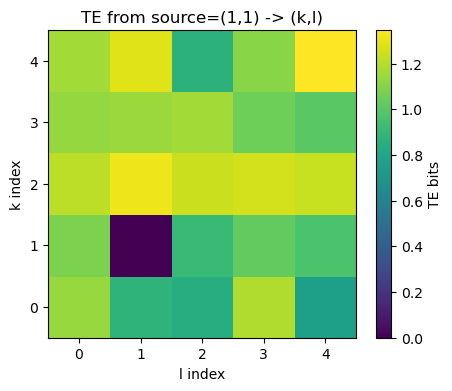

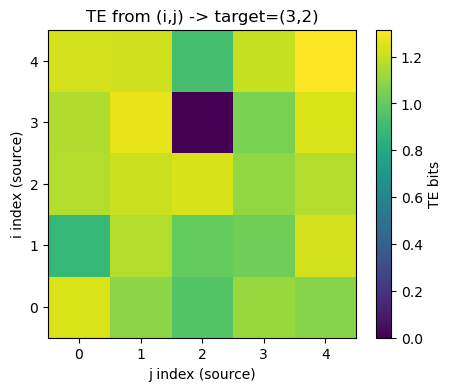

In [16]:
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from tqdm import tqdm

    # (Existing code to generate 'field', compute 'te_mat', etc.)
    T = 100
    Nx, Ny = 5, 5
    field = np.random.randn(T, Nx, Ny)
    for t in range(1, T):
        field[t, 3, 2] += 0.8 * field[t-1, 1, 1]
    te_mat = measure_spatial_te(field, bins=8, lag=1)

    # 1. Plot TE from a single source
    i_s, j_s = (1, 1)
    te_from_source = te_mat[i_s, j_s, :, :]
    plt.figure(figsize=(5, 4))
    plt.imshow(te_from_source, origin='lower', cmap='viridis')
    plt.colorbar(label='TE bits')
    plt.title(f"TE from source=({i_s},{j_s}) -> (k,l)")
    plt.xlabel('l index')
    plt.ylabel('k index')
    plt.show()

    # 2. Plot TE to a single target
    k_t, l_t = (3, 2)
    te_to_target = te_mat[:, :, k_t, l_t]
    plt.figure(figsize=(5, 4))
    plt.imshow(te_to_target, origin='lower', cmap='viridis')
    plt.colorbar(label='TE bits')
    plt.title(f"TE from (i,j) -> target=({k_t},{l_t})")
    plt.xlabel('j index (source)')
    plt.ylabel('i index (source)')
    plt.show()
